# Unsupervised Clustering on stl-10 using DBSCAN on DINO Features

## Load train features and labels

In [1]:
import os
import torch

processed_data_path = '/kaggle/input/stl-10-processed/train_data.pt'

if os.path.exists(processed_data_path):
    checkpoint = torch.load(processed_data_path)
    train_features = checkpoint['train_features']
    train_labels = checkpoint['train_labels']
    print("Loaded train_features and train_labels from train_data.pt.")

Loaded train_features and train_labels from train_data.pt.


/tmp/ipykernel_30/164499837.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(processed_data_path)


## Clustering Accuracy calculation using Hungarian algorithm

In [2]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import torch

import numpy as np
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Ensure labels are within [0, D-1] range
    y_true = y_true - np.min(y_true)
    y_pred = y_pred - np.min(y_pred)

    # Find number of classes (D)
    D = max(y_pred.max(), y_true.max()) + 1

    # Build the contingency matrix (confusion matrix)
    contingency_matrix = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        contingency_matrix[y_pred[i], y_true[i]] += 1

    # Use Hungarian algorithm (linear sum assignment) to find the best match
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # Calculate clustering accuracy
    accuracy = contingency_matrix[row_ind, col_ind].sum() / y_pred.size
    
    # Create a new array to store the final mapped labels
    mapped_labels = np.full_like(y_pred, -1)  # Initialize with -1 (unmapped labels)

    # Assign the mapped labels
    for i in range(len(row_ind)):
        mapped_labels[y_pred == row_ind[i]] = col_ind[i]
    
    return accuracy * 100, mapped_labels  # Return accuracy and the final mapped labels

### Load val set

In [3]:
import os
import torch

processed_data_path = '/kaggle/input/stl-10-processed/val_data.pt'

if os.path.exists(processed_data_path):
    checkpoint = torch.load(processed_data_path)
    val_features = checkpoint['val_features']
    val_labels = checkpoint['val_labels']
    print("Loaded val_features and val_labels from val_data.pt.")

Loaded val_features and val_labels from val_data.pt.


/tmp/ipykernel_30/1547976315.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(processed_data_path)


### Load test set

In [4]:
import os
import torch

processed_data_path = '/kaggle/input/stl-10-processed/test_data.pt'

if os.path.exists(processed_data_path):
    checkpoint = torch.load(processed_data_path)
    test_features = checkpoint['test_features']
    test_labels = checkpoint['test_labels']
    print("Loaded test_features and test_labels from test_data.pt.")

Loaded test_features and test_labels from test_data.pt.


/tmp/ipykernel_30/3420152361.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(processed_data_path)


## Initialize DBSCAN

### Hyperparameter Tuning for eps and min_samples

In [7]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm

def tune_dbscan(features, eps_range, min_samples_range):
    """
    Tune DBSCAN hyperparameters using silhouette score.
    
    Parameters:
        features (ndarray): Feature matrix.
        eps_range (list): Range of values for the `eps` parameter.
        min_samples_range (list): Range of values for `min_samples`.
    
    Returns:
        dict: Best hyperparameters and silhouette score.
    """
    best_params = {'eps': None, 'min_samples': None, 'silhouette_score': -1}
    results = []
    print("Tuning DBSCAN Hyperparameters...")
    for eps in tqdm(eps_range, desc="Eps values"):
        for min_samples in tqdm(min_samples_range, desc="Min samples values", leave=False):
            # Fit DBSCAN with current parameters
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(features)
            
            # Ignore runs where all points are classified as noise (-1)
            if len(np.unique(labels)) <= 1:
                continue
            
            # Calculate silhouette score
            score = silhouette_score(features, labels)
            results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': score})
            # Update best parameters if current score is higher
            if score > best_params['silhouette_score']:
                best_params = {'eps': eps, 'min_samples': min_samples, 'silhouette_score': score}
    
    return best_params, results

# Example Usage
eps_values = np.linspace(0.1, 2.0, 20)  # Eps range
min_samples_values = range(2, 10)  # Min samples range

# Assume `train_features` is your feature matrix
best_params, results = tune_dbscan(train_features, eps_values, min_samples_values)

print("Best Parameters:")
print(f"Eps: {best_params['eps']}, Min Samples: {best_params['min_samples']}, Silhouette Score: {best_params['silhouette_score']}")


Tuning DBSCAN Hyperparameters...


Eps values: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]      

Best Parameters:
Eps: 0.8999999999999999, Min Samples: 7, Silhouette Score: 0.05922530218958855


### Initialize DBSCAN with optimal hyperparameters and fit on train set

In [8]:
eps, min_samples = best_params['eps'], best_params['min_samples']
# eps, min_samples = 1, 10
clustering_module = DBSCAN(eps=eps, min_samples=min_samples)
clustering_module.fit_predict(train_features)

array([ 0, -1, -1, ...,  0,  1,  1])

### New Prediction functions

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

def predict_dbscan_labels(dbscan_model, new_data, eps):
    """
    Predicts the cluster labels for new data points using a trained DBSCAN model.

    Parameters:
    - dbscan_model: Trained DBSCAN model
    - new_data: Array of new data points (shape: [n_samples, n_features])
    - eps: The epsilon value used in the DBSCAN model
    
    Returns:
    - predicted_labels: List of predicted labels for each data point in `new_data`.
                        -1 indicates the point is considered noise.
    """
    # Check if the model has been fitted
    if not hasattr(dbscan_model, "components_"):
        raise ValueError("The DBSCAN model is not fitted. Call `fit` before predicting.")

    # Extract core samples and their labels
    core_samples = dbscan_model.components_
    core_labels = dbscan_model.labels_[dbscan_model.core_sample_indices_]

    # Train a Nearest Neighbors model on core samples
    nn = NearestNeighbors(radius=eps)
    nn.fit(core_samples)

    # Predict labels for new data points
    distances, indices = nn.kneighbors(new_data)
    predicted_labels = []

    for dist, idx in zip(distances, indices):
        if dist[0] <= eps:  # Within eps radius
            predicted_labels.append(core_labels[idx[0]])
        else:
            predicted_labels.append(-1)  # Treat as noise

    return predicted_labels


### Accuracy on Train split

In [10]:
predictions = predict_dbscan_labels(clustering_module, train_features, eps)

acc_score, mapped_labels = clustering_accuracy(train_labels, predictions)

print("Train ACC score:", acc_score)

Train ACC score: 36.175000000000004


### Accuracy on Val split

In [11]:
predictions = predict_dbscan_labels(clustering_module, val_features, eps)

acc_score, mapped_labels = clustering_accuracy(val_labels, predictions)

print("Train ACC score:", acc_score)

Train ACC score: 36.1


### Accuracy on Test split

In [12]:
predictions = predict_dbscan_labels(clustering_module, test_features, eps)

acc_score, mapped_labels = clustering_accuracy(test_labels, predictions)

print("Train ACC score:", acc_score)

Train ACC score: 36.2875


## NMI Score on Test split

In [14]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(test_labels, predictions)
print(f"Normalized Mutual Information (NMI): {100*nmi}")

Normalized Mutual Information (NMI): 54.462789005041955


## ARI Score on Test split

In [16]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(test_labels, predictions)
print(f"Adjusted Rand Index (ARI): {100*ari}")

Adjusted Rand Index (ARI): 30.371587744309007


## t-SNE Plots

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
def plot_tsne(features, predictions, num_classes, title="t-SNE Visualization"):
    if isinstance(features, torch.Tensor):
        features = features.cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_features = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1],
        c=predictions, cmap=plt.cm.get_cmap("tab10", num_classes),
        alpha=0.7, edgecolor='k', s=15
    )
    plt.colorbar(scatter, ticks=range(num_classes))
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()


### t-SNE on Actual test labels

/tmp/ipykernel_30/2874319743.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c=predictions, cmap=plt.cm.get_cmap("tab10", num_classes),


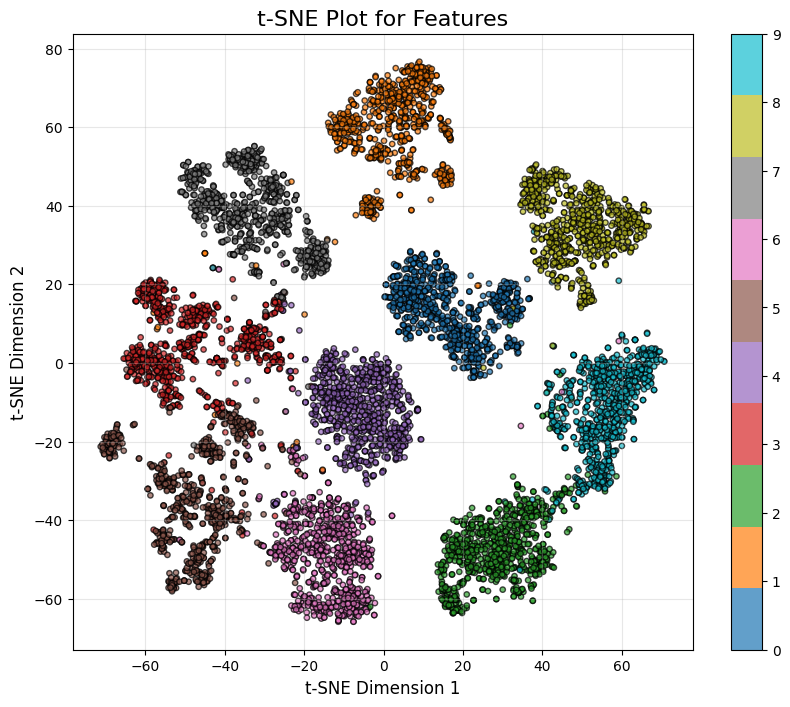

In [18]:
num_classes = len(np.unique(test_labels))  # Get the number of unique classes
plot_tsne(test_features, test_labels, num_classes, title="t-SNE Plot for Features")

### t-SNE on predicted test labels

/tmp/ipykernel_30/2874319743.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c=predictions, cmap=plt.cm.get_cmap("tab10", num_classes),


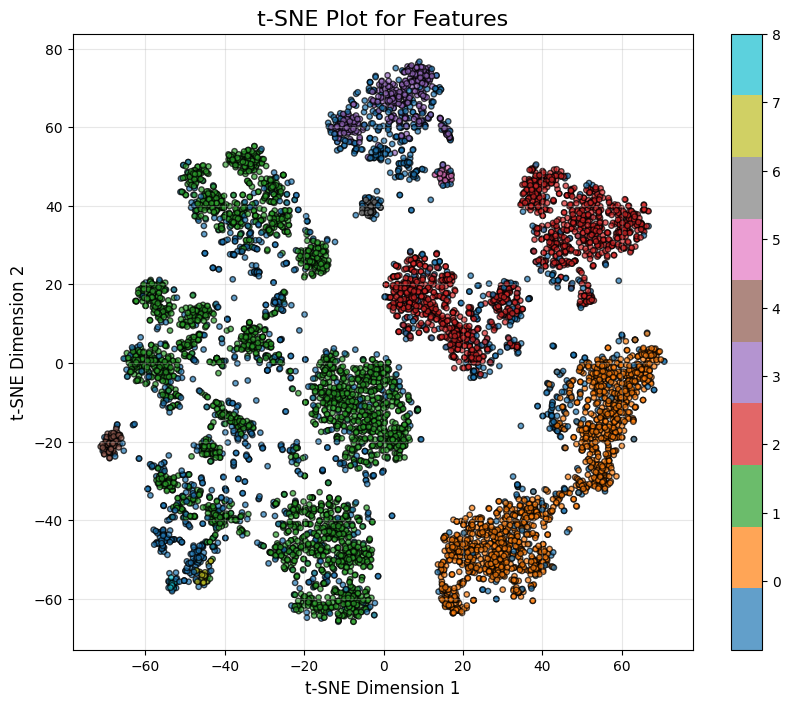

In [19]:
num_classes = len(np.unique(predictions))  # Get the number of unique classes
plot_tsne(test_features, predictions, num_classes, title="t-SNE Plot for Features")